In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C
import os
import mahotas as mh
import nibabel as nib
import nrrd
import skimage.morphology
import cv2
from skimage.filters import threshold_otsu

In [3]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

2024-05-05 11:08:27.042516: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-05 11:08:29.582277: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 11:08:29.583570: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-05 11:08:29.926450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-05 11:08:29.928952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 3

True

In [4]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'
CAPATH='/raid/mpsych/CACTAS/DATA/CA24'

In [5]:
images, labels = C.Helper.load_data(DATAPATH)

In [6]:
masks = C.Helper.load_seg_data(CAPATH)

In [7]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.split_patients_masks(images, labels, masks)

In [8]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.normalization2(DATAPATH, CAPATH, X_train, y_train, m_train, X_test, y_test, m_test)

In [9]:
slice_to_patient_mapping, last_key = C.Helper.map_and_key(y_train)

In [10]:
X_train, y_train, X_test, y_test = C.Helper.extract_slices(X_train, y_train, X_test, y_test)

(13730, 512, 512, 1) (13730, 512, 512, 1) (3036, 512, 512, 1) (3036, 512, 512, 1)


In [11]:
m_train, m_test = C.Helper.extract_masks_slices(m_train, m_test)

(13730, 512, 512, 1) (3036, 512, 512, 1)


In [12]:
X_train, y_train, m_train = C.Helper.filter_slices(X_train, y_train, m_train)

(564, 512, 512, 1) (564, 512, 512, 1) (564, 512, 512, 1)


In [13]:
X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype

(dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'))

In [14]:
m_train.dtype

dtype('float64')

In [15]:
train_masks=[]
for i in range(len(m_train)):
    binary = (m_train[i] > 0).astype(np.uint8)
    train_masks.append(binary)

In [16]:
train_images=[]
for i in range(len(X_train)):
    train_image = X_train[i] * train_masks[i]
    train_images.append(train_image)
train_images_array = np.array(train_images)

In [17]:
#train_images_array = train_images_array.astype(np.float32)

In [18]:
train_images_array = train_images_array.reshape(train_images_array.shape[0], train_images_array.shape[1],train_images_array.shape[2], 1)

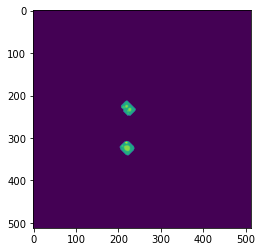

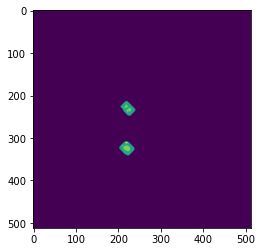

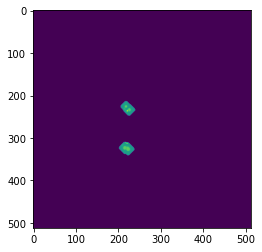

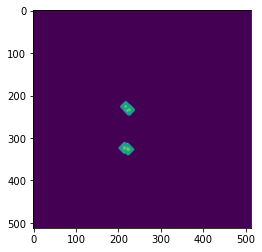

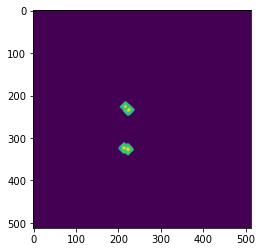

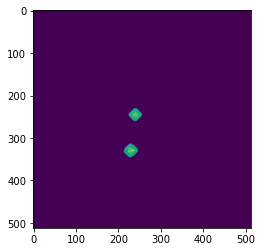

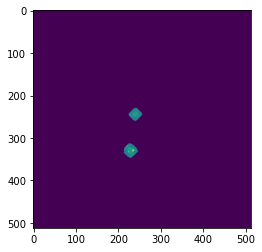

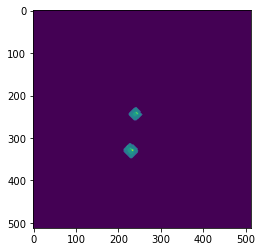

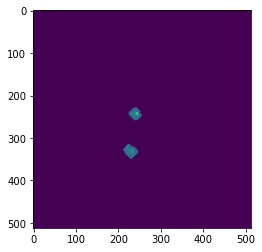

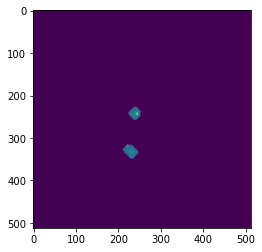

In [19]:
# for i in range(10, 20):
#     plt.imshow(train_images[i])
#     plt.show()

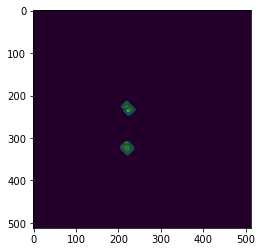

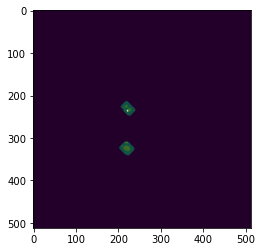

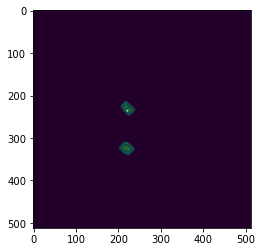

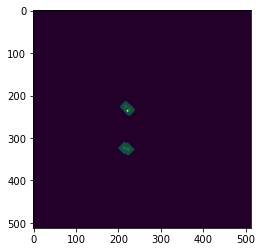

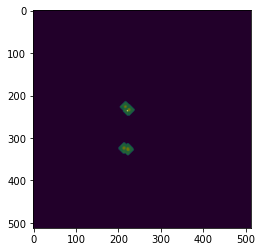

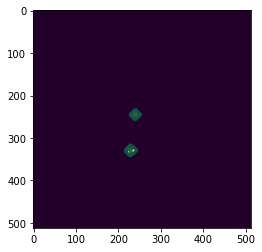

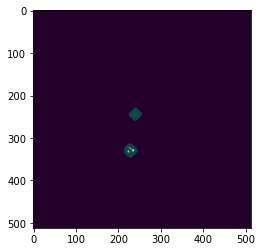

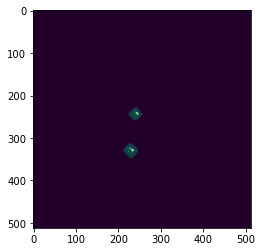

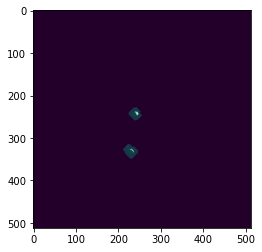

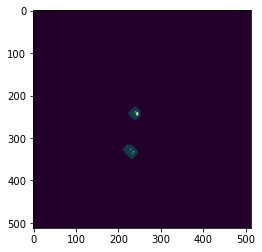

In [20]:
# for i in range(10, 20):
#     plt.imshow(train_images[i])
#     plt.imshow(y_train[i], cmap='gray', alpha=0.5)
#     plt.show()

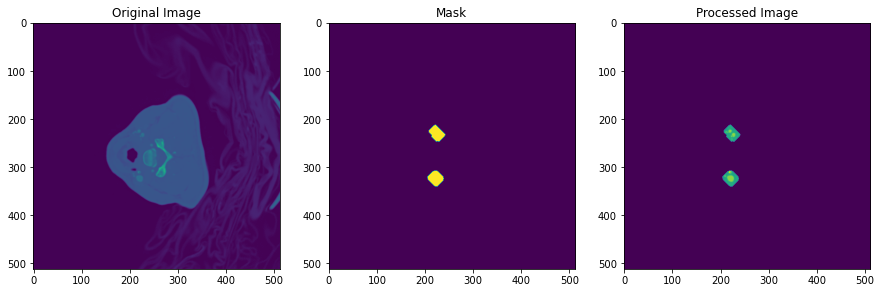

In [21]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# axes[0].imshow(X_train[10], vmin=0, vmax=1)
# axes[0].set_title('Original Image')
# axes[1].imshow(train_masks[10])
# axes[1].set_title('Mask')
# axes[2].imshow(train_images[10])
# axes[2].set_title('Processed Image')
# plt.show()

In [22]:
test_masks=[]
for i in range(len(m_test)):
    binary = (m_test[i] > 0).astype(np.uint8)
    test_masks.append(binary)

In [23]:
test_images=[]
for i in range(len(X_test)):
    test_image = X_test[i] * test_masks[i]
    test_images.append(test_image)
test_images_array = np.array(test_images)

In [24]:
#test_images_array = test_images_array.astype(np.float32)

In [25]:
test_images_array = test_images_array.reshape(test_images_array.shape[0], test_images_array.shape[1],test_images_array.shape[2], 1)

In [26]:
X_train_set = train_images_array[:last_key]
y_train_set = y_train[:last_key]
X_val = train_images_array[last_key:]
y_val = y_train[last_key:]

In [27]:
#y_train_set = y_train_set.astype(np.float32)

In [28]:
#y_val = y_val.astype(np.float32)

In [29]:
X_train_set.dtype, y_train_set.dtype

(dtype('float64'), dtype('float64'))

In [30]:
X_val.dtype, y_val.dtype

(dtype('float64'), dtype('float64'))

In [31]:
test_images_array.dtype, y_test.dtype

(dtype('float64'), dtype('float64'))

In [32]:
X_val.shape, y_val.shape

((128, 512, 512, 1), (128, 512, 512, 1))

In [33]:
model = C.Helper.create_unet(X_train_set[0].shape)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


2024-05-05 11:12:48.144574: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-05 11:12:48.147118: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-05 11:12:48.157315: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1
2024-05-05 11:12:48.160246: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-05 11:12:48.162720: I tensorflow/core

In [34]:
model, history = C.Helper.train_unet(X_train_set, y_train_set, X_val, y_val, model, epochs=200)

2024-05-05 11:12:49.279394: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-05-05 11:12:49.302822: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245740000 Hz


Epoch 1/200


2024-05-05 11:12:50.682961: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-05 11:12:51.681203: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-05-05 11:12:52.923968: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-05-05 11:12:52.923991: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-05-05 11:12:52.924411: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-05 11:12:53.020033: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-05 11:12:54.113324: I tensorflow/stream_exec

13/13 [==============================] - 36s 1s/step - loss: 0.2292 - iou: 3.3694e-04 - iou_thresholded: 6.5484e-04 - val_loss: 0.0016 - val_iou: 4.6902e-04 - val_iou_thresholded: 8.8056e-04
Epoch 2/200
13/13 [==============================] - 27s 1s/step - loss: 0.0018 - iou: 0.0021 - iou_thresholded: 7.8413e-04 - val_loss: 0.0014 - val_iou: 0.0068 - val_iou_thresholded: 8.8056e-04
Epoch 3/200
13/13 [==============================] - 13s 1s/step - loss: 0.0011 - iou: 0.0072 - iou_thresholded: 7.7902e-04 - val_loss: 0.0011 - val_iou: 0.0100 - val_iou_thresholded: 8.8056e-04
Epoch 4/200
13/13 [==============================] - 13s 1s/step - loss: 0.0012 - iou: 0.0101 - iou_thresholded: 7.4006e-04 - val_loss: 0.0014 - val_iou: 0.0162 - val_iou_thresholded: 8.8056e-04
Epoch 5/200
13/13 [==============================] - 13s 1s/step - loss: 0.0010 - iou: 0.0137 - iou_thresholded: 8.2615e-04 - val_loss: 0.0011 - val_iou: 0.0215 - val_iou_thresholded: 8.8056e-04
Epoch 6/200
13/13 [==========

Epoch 43/200
13/13 [==============================] - 14s 1s/step - loss: 2.2720e-04 - iou: 0.4740 - iou_thresholded: 0.5856 - val_loss: 5.3430e-04 - val_iou: 0.3235 - val_iou_thresholded: 0.4752
Epoch 44/200
13/13 [==============================] - 13s 1s/step - loss: 2.3118e-04 - iou: 0.4914 - iou_thresholded: 0.5967 - val_loss: 4.9645e-04 - val_iou: 0.3560 - val_iou_thresholded: 0.4983
Epoch 45/200
13/13 [==============================] - 13s 1s/step - loss: 2.2317e-04 - iou: 0.4855 - iou_thresholded: 0.6046 - val_loss: 5.1306e-04 - val_iou: 0.3640 - val_iou_thresholded: 0.4802
Epoch 46/200
13/13 [==============================] - 13s 1s/step - loss: 2.1448e-04 - iou: 0.5171 - iou_thresholded: 0.6374 - val_loss: 4.6366e-04 - val_iou: 0.3949 - val_iou_thresholded: 0.5012
Epoch 47/200
13/13 [==============================] - 13s 1s/step - loss: 2.0480e-04 - iou: 0.5008 - iou_thresholded: 0.6248 - val_loss: 5.2491e-04 - val_iou: 0.3476 - val_iou_thresholded: 0.4586
Epoch 48/200
13/13 [

Epoch 85/200
13/13 [==============================] - 14s 1s/step - loss: 1.0115e-04 - iou: 0.6967 - iou_thresholded: 0.7815 - val_loss: 7.9198e-04 - val_iou: 0.4389 - val_iou_thresholded: 0.5009
Epoch 86/200
13/13 [==============================] - 13s 1s/step - loss: 1.0055e-04 - iou: 0.6979 - iou_thresholded: 0.7840 - val_loss: 7.1707e-04 - val_iou: 0.4801 - val_iou_thresholded: 0.5192
Epoch 87/200
13/13 [==============================] - 13s 1s/step - loss: 9.3908e-05 - iou: 0.7083 - iou_thresholded: 0.7889 - val_loss: 6.9286e-04 - val_iou: 0.4590 - val_iou_thresholded: 0.5131
Epoch 88/200
13/13 [==============================] - 13s 1s/step - loss: 9.5997e-05 - iou: 0.7123 - iou_thresholded: 0.7942 - val_loss: 8.4193e-04 - val_iou: 0.4320 - val_iou_thresholded: 0.4802
Epoch 89/200
13/13 [==============================] - 13s 1s/step - loss: 9.2823e-05 - iou: 0.7147 - iou_thresholded: 0.7920 - val_loss: 9.1066e-04 - val_iou: 0.4312 - val_iou_thresholded: 0.4655
Epoch 90/200
13/13 [

Epoch 127/200
13/13 [==============================] - 14s 1s/step - loss: 5.2278e-05 - iou: 0.8345 - iou_thresholded: 0.8823 - val_loss: 0.0011 - val_iou: 0.4787 - val_iou_thresholded: 0.5007
Epoch 128/200
13/13 [==============================] - 13s 1s/step - loss: 4.5714e-05 - iou: 0.8391 - iou_thresholded: 0.8970 - val_loss: 0.0011 - val_iou: 0.4702 - val_iou_thresholded: 0.4891
Epoch 129/200
13/13 [==============================] - 13s 1s/step - loss: 4.2375e-05 - iou: 0.8514 - iou_thresholded: 0.9052 - val_loss: 0.0012 - val_iou: 0.4682 - val_iou_thresholded: 0.4840
Epoch 130/200
13/13 [==============================] - 13s 1s/step - loss: 3.7729e-05 - iou: 0.8561 - iou_thresholded: 0.9078 - val_loss: 0.0012 - val_iou: 0.4792 - val_iou_thresholded: 0.4982
Epoch 131/200
13/13 [==============================] - 13s 1s/step - loss: 3.8813e-05 - iou: 0.8696 - iou_thresholded: 0.9160 - val_loss: 0.0012 - val_iou: 0.4862 - val_iou_thresholded: 0.4985
Epoch 132/200
13/13 [==============

13/13 [==============================] - 14s 1s/step - loss: 1.2050e-05 - iou: 0.9551 - iou_thresholded: 0.9771 - val_loss: 0.0019 - val_iou: 0.4698 - val_iou_thresholded: 0.4739
Epoch 170/200
13/13 [==============================] - 13s 1s/step - loss: 1.5698e-05 - iou: 0.9455 - iou_thresholded: 0.9674 - val_loss: 0.0019 - val_iou: 0.4557 - val_iou_thresholded: 0.4599
Epoch 171/200
13/13 [==============================] - 13s 1s/step - loss: 1.7762e-05 - iou: 0.9401 - iou_thresholded: 0.9610 - val_loss: 0.0016 - val_iou: 0.4604 - val_iou_thresholded: 0.4656
Epoch 172/200
13/13 [==============================] - 13s 1s/step - loss: 2.2846e-05 - iou: 0.9321 - iou_thresholded: 0.9564 - val_loss: 0.0014 - val_iou: 0.4857 - val_iou_thresholded: 0.4935
Epoch 173/200
13/13 [==============================] - 13s 1s/step - loss: 3.1681e-05 - iou: 0.9086 - iou_thresholded: 0.9349 - val_loss: 0.0017 - val_iou: 0.4558 - val_iou_thresholded: 0.4605
Epoch 174/200
13/13 [============================

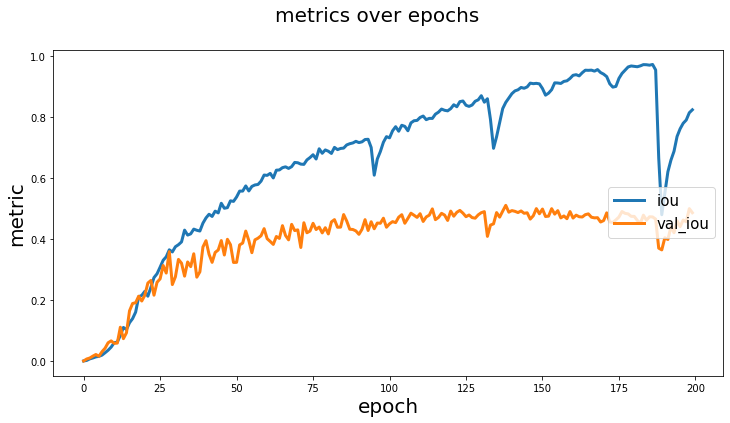

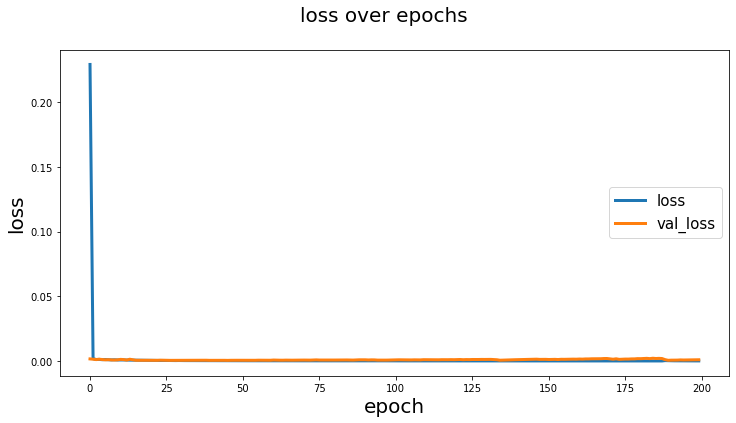

In [35]:
C.Helper.visualize_graph(history)

In [36]:
y_pred = C.Helper.prediction(test_images_array, model)

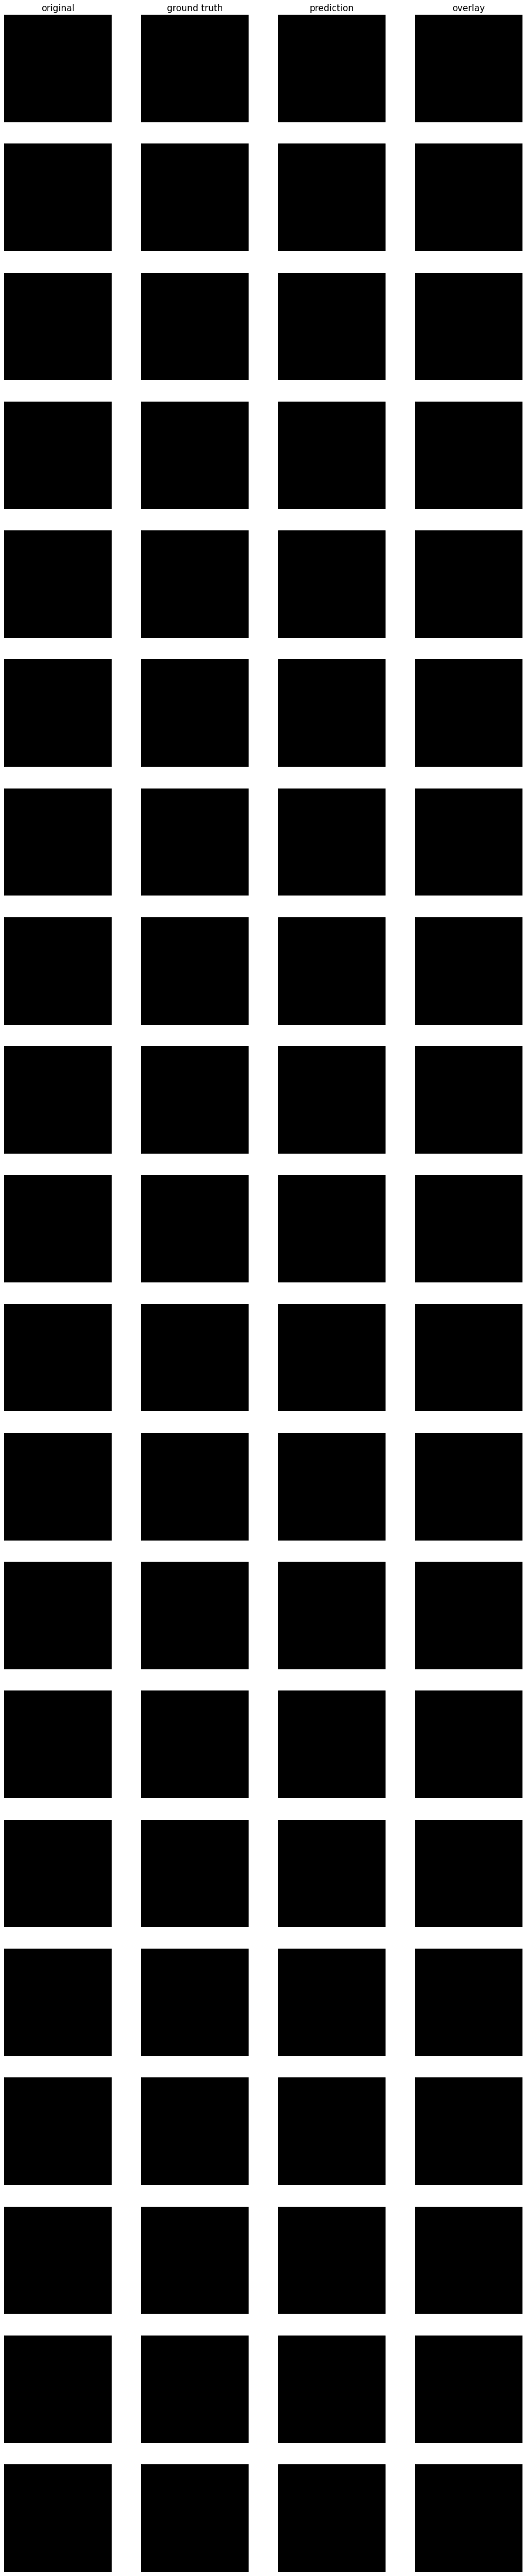

In [37]:
C.Helper.visualize_result(test_images_array, y_test, y_pred)

In [38]:
C.Helper.evaluate(test_images_array, y_test, model)

95/95 [==============================] - 21s 222ms/step - loss: 1.0345e-04 - iou: 0.4744 - iou_thresholded: 0.5186
